In [1]:
import numpy as np
fpath = '/checkpoint/massran/async_maopy_playground/qp/n{world_size}/{alg}/r{rank}_n{world_size}.npz'

In [2]:
def load_data(world_size=2, alg='gp', rank='0'):
    arg_list, time_list = [], []
    data = np.load(fpath.format(world_size=world_size, alg=alg, rank=rank))['argmin_est'].item()
    for itr in data:
        t, v = data[itr]
        arg_list.append(v.flatten())
        time_list.append(t)
    return time_list, arg_list

In [3]:
def load_objective(fpath='qp_data_sg.npz'):
    data_fpath = './datasets/' + fpath
    data = np.load(data_fpath)
    a_m = data['A']
    b_v = data['b']
    print(a_m.shape, b_v.shape)
    return lambda x: .5 * np.linalg.norm(a_m.dot(x) - b_v)**2

In [4]:
def get_world_data(world_size=2, alg='gp'):
    time_list, arg_list = [], []
    for rank in range(world_size):
        tl, al = load_data(rank=rank, world_size=world_size, alg=alg)
        time_list += tl
        arg_list += al
        break
    time_list = np.array(time_list)
    arg_list = np.array(arg_list)
    sorted_indices = np.argsort(time_list)
    arg_list = arg_list[sorted_indices]
    time_list = time_list[sorted_indices]
    objective = load_objective()
    y_list = np.array(list(map(objective, arg_list)))
    return time_list, y_list

In [18]:
alg_list = ['agp', 'gp']
world_size_list = [2]
data_dict = {}
for alg in alg_list:
    data_dict[alg] = {}
    data_dict[alg]['time'] = []
    data_dict[alg]['globj'] = []
    for ws in world_size_list:
        tl, yl = get_world_data(ws, alg)
        data_dict[alg]['time'].append(tl)
        data_dict[alg]['globj'].append(yl)

(2560000, 50) (2560000,)
(2560000, 50) (2560000,)


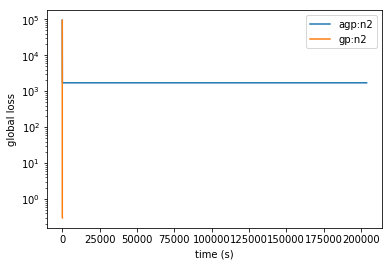

In [19]:
import matplotlib.pyplot as plt
for alg in data_dict:
    time_list = data_dict[alg]['time']
    globj_list = data_dict[alg]['globj']
    for i, tup in enumerate(zip(time_list, globj_list)):
        tl, yl = tup
        plt.semilogy(yl, label='%s:n%s' % (alg, 2**(i + 1)))
plt.xlabel('time (s)')
plt.ylabel('global loss')
plt.legend()
plt.show()